## Assignment 06

**Students:**
- Franklin Ruben Rosembluth Prado
- Sharon Sarai Maygua Mendiola

In [351]:
import numpy as np
import gym
from gym import spaces
import random
from copy import copy
from termcolor import colored, cprint
import time
import math
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from PIL import Image

In [352]:
# 0 = empty_space; 1 = init_pos; 2 = goal_pos
def create_map(size, init_position, goal_pos):
    map = np.zeros((size[1], size[0]), dtype=np.int)
    map[init_position[1], init_position[0]] = 1
    map[goal_pos[1], goal_pos[0]] = 2
    return map

In [353]:
map_size = (9, 7)
init_pos = (1, 1)
goal_pos = (7, 4)
map = create_map(map_size, init_pos, goal_pos)
print(map)

[[0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [354]:
action_space_size = 8 #UP, RIGHT, DOWN, LEFT UP_RIGHT, ..., DOWN_LEFT
state_space_size = map_size[0] * map_size[1] #AREA
print(action_space_size, state_space_size)

q_table = np.zeros((state_space_size, action_space_size))

print(q_table.shape)

8 63
(63, 8)


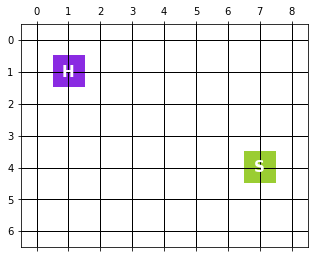

In [355]:
def show_map(map):
    row_labels, col_labels = range(map.shape[0]), range(map.shape[1])
    cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
    norm = Normalize(vmin=0, vmax=2)
    plt.matshow(map, cmap=cmap, norm=norm)
    plt.xticks(col_labels, col_labels)
    plt.yticks(row_labels, row_labels)
    plt.grid(color='k', linewidth=1)
    init = np.where(map == 1)
    plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', fontsize=15)
    goal = np.where(map == 2)
    plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', fontsize=15)
    plt.show()

show_map(map)

In [356]:
all_colors = plt.cm.colors.cnames.keys()
print(all_colors)

dict_keys(['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lights

Creating environment from:
- https://www.gymlibrary.dev/content/environment_creation/

In [357]:
class AzkabanEnviroment:
    def __init__(self, map, size, init_pos, goal_pos, prob_A=0.9, prob_B=0.8, prob_C=0.9):
        self.map = map
        self.size = size
        self.harry_pos = init_pos
        self.sirius_pos = goal_pos
        self.reset_map = map
        self.reset_harry_pos = init_pos
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Discrete(self.map.shape[0] * self.map.shape[1])
        self.prob_A = prob_A
        self.prob_B = prob_B
        self.prob_C = prob_C
        self._action_to_direction = {
            0: "left",
            1: "right",
            2: "up",
            3: "down",
            4: "up_right",
            5: "up_left",
            6: "down_right",
            7: "down_left"
        }
        self.rewards = {
            "walk": -1,
            "fall": -5,
            "goal": 100
        }
    
    def get_rewards(self):
        return self.rewards
    
    def set_rewards(self, walk , fall, goal):
        self.rewards = {
            "walk": walk,
            "fall": fall,
            "goal": goal
        }

    def __str__(self):
        return f"Harry Position: ({self.harry_pos[0]}, {self.harry_pos[1]})\n" + str(self.map)

    def render(self):
        row_labels, col_labels = range(map.shape[0]), range(map.shape[1])
        cmap = ListedColormap(['white', 'blueviolet', 'yellowgreen'])
        norm = Normalize(vmin=0, vmax=2)
        plt.matshow(map, cmap=cmap, norm=norm)
        plt.xticks(col_labels, col_labels)
        plt.yticks(row_labels, row_labels)
        plt.grid(color='k', linewidth=1)
        init = np.where(map == 1)
        plt.text(init[1][0], init[0][0], 'H', ha='center', va='center', color='white', weight='bold', fontsize=15)
        goal = np.where(map == 2)
        plt.text(goal[1][0], goal[0][0], 'S', ha='center', va='center', color='white', weight='bold', fontsize=15)
        plt.show()
    
    def reset(self):
        self.map = self.reset_map
        self.harry_pos = self.reset_harry_pos
        return ((10 * self.harry_pos[0]) + self.harry_pos[1]) #given state

    def is_goal_state(self):
        return self.harry_pos == self.sirius_pos
    
    def has_fallen_of_map(self):
        x_range = np.array(range(self.size[0]))
        y_range = np.array(range(self.size[1]))
        return (self.harry_pos[0] not in x_range) or (self.harry_pos[1] not in y_range)
    
    def move_harry_right(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[0] += 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()

    def move_harry_left(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[0] -= 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()
    
    def move_harry_up(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[1] -= 1
        self.harry_pos = list(self.harry_pos)
        return self.get_move_result()

    def move_harry_down(self):
        self.harry_pos = list(self.harry_pos)
        self.harry_pos[1] += 1
        self.harry_pos = tuple(self.harry_pos)
        return self.get_move_result()
    
    def move_harry_up_right(self):
        self.move_harry_up()
        self.move_harry_right()
        return self.get_move_result()

    def move_harry_up_left(self):
        self.move_harry_up()
        self.move_harry_left()
        return self.get_move_result()

    def move_harry_down_right(self):
        self.move_harry_down()
        self.move_harry_right()
        return self.get_move_result()

    def move_harry_down_left(self):
        self.move_harry_down()
        self.move_harry_left()
        return self.get_move_result()
    
    def get_move_result(self):
        move = (10 * self.harry_pos[0] + self.harry_pos[1]) #state
        if self.is_goal_state():
            return move, self.rewards["goal"], True
        if self.has_fallen_of_map():
            return move, self.rewards["fall"], True
        
        self.map = create_map(self.size, self.harry_pos, self.sirius_pos)
        return move, self.rewards["walk"], False
        
    def step(self, action):
        direction = self._action_to_direction[action]
        if direction == "left":
            new_state, reward, done = self.move_harry_left()
        elif direction == "right":
            new_state, reward, done = self.move_harry_right()
        elif direction == "up":
            new_state, reward, done = self.move_harry_up()
        elif direction == "down":
            new_state, reward, done = self.move_harry_down()
        elif direction == "up_right":
            new_state, reward, done = self.move_harry_up_right()
        elif direction == "up_left":
            new_state, reward, done = self.move_harry_up_left()
        elif direction == "down_right":
            new_state, reward, done = self.move_harry_down_right()
        elif direction == "down_left":
            new_state, reward, done = self.move_harry_down_left()
            
        # probability windy columns
        if self.harry_pos[0] == 3:
            random_number = np.random.rand()
            if random_number <= self.prob_A:
                new_state, reward, done = self.move_harry_up()

        if self.harry_pos[0] == 4:
            random_number = np.random.rand()
            if random_number <= self.prob_B:
                new_state, reward, done = self.move_harry_up()
                new_state, reward, done = self.move_harry_up()

        if self.harry_pos[0] == 5:
            random_number = np.random.rand()
            if random_number <= self.prob_C:
                new_state, reward, done = self.move_harry_up()

        return new_state, reward, done

Create Azkaban environment as follows:

In [358]:
map_size = (9, 7)
init_pos = (1, 1)
goal_pos = (7, 4)
azkaban_map = create_map(map_size, init_pos, goal_pos)
env = AzkabanEnviroment(azkaban_map, map_size, init_pos, goal_pos)

Render the environment:

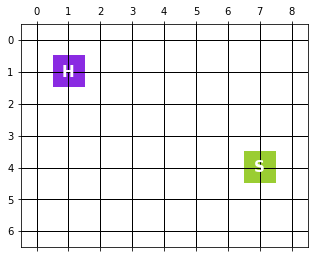

In [359]:
env.render()

Get states and actions for the lake.

In [360]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

print((action_space_size, state_space_size))

(8, 63)


Move the agent: 

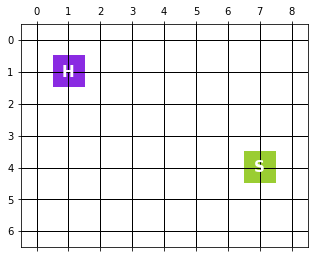

In [361]:
action = 1
state = env.reset() #+10
new_state, reward, done = env.step(action)
env.render()